## Natural Language Processing of Commerical Legal Contracts
_Author: Weicheng Wang_

---

## 1. Introduction

Modern commercial legal contracts are very long and complex agreements. A typical merger and acquistition ('M&A') contract can be over 100 pages long, and useful information can be buried in blocks of long text. 

Sometimes, lawyers will want to know information that can only be accessed by aggregating hundreds, or even thousands of agreements. For instance, how many major M&As have been governed by Delaware law in the last year? How many M&As have stringent indemnification provisions?

Traditionally, owing to the difficulty of parsing unstructured text data, this information could only be gleaned manually and at great cost. Teams of contract attorneys would be hired to painstakingly read thousands of agreements and manually tag data points. Now, law firms are increasingly turning to machine learning to speed up the process.

---

In this exercise, we will attempt to positively identify one particular data point from a sample of merger agreements. The data point we seek is called a 'basket', and it lies in a section of the merger agreement known as the 'indemnification' section. 

As background, indemnification is a legal concept which states that when something goes wrong according to a set of pre-set conditions in a contract, the party providing indemnification will cover the costs for the person who was wronged.

A basket, in the context of indemnification, is like a healthcare deductible: you must meet a threshhold before insurance will begin paying.

Below is an example of an actual basket in an indemnification provision in *italics*:

9.6.          Limitation on Indemnity. 
    
   (a)          Notwithstanding anything to the contrary set forth herein, the Indemnified Parties shall not make a claim against the Company Holders or Buyer, as applicable, for indemnification for Buyer Losses or Holder Losses, as the case may be, under this Agreement *unless and until the aggregate amount of such Buyer Losses or Holder Losses, as the case may be, exceeds 500,000 (the “Basket”)*, in which event the Indemnified Parties may claim indemnification for all Buyer Losses or Holder Losses, as the case may be, including those credited toward the Basket...'

## 2. Data Exploration & Analysis

In [1]:
# import packages

import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, preprocessing, metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

%matplotlib inline

ImportError: No module named pandas

In [194]:
df = pd.read_excel('/Users/wangw6/Downloads/Indemnification Basket Examples.xlsx')

# for our initial analysis, we will use a dataframe that only contains text 
#(there are some columns that are not relevant that we will drop)

In [195]:
df.shape

(1005, 3)

In [196]:
df.head()

,DocClause,Length,IsBasket
0,ARTICLE 10 INDEMNIFICATION AND OTHER REMEDIES....,679,0
1,"5. Indemnification, Etc ➤ 5.5 Limitations on I...",875,0
2,ARTICLE VII INDEMNIFICATION ➤ Section 7.2 Inde...,330,0
3,ARTICLE XII. INDEMNIFICATION ➤ 12.3 Indemnific...,1427,0
4,ARTICLE X INDEMNIFICATION ➤ 10.2 Survival and ...,332,0


In [197]:
df.isnull().sum()

#let's check if we have any nulls

DocClause    0
Length       0
IsBasket     0
dtype: int64

In [198]:
print(df['IsBasket'].value_counts(normalize=True))
print(df['IsBasket'].value_counts())

#'0' means the clause has been manually tagged as NOT containing a basket. '1' means it has a basket.

0    0.503483
1    0.496517
Name: IsBasket, dtype: float64
0    506
1    499
Name: IsBasket, dtype: int64


In [199]:
vect = CountVectorizer(stop_words = 'english', lowercase=False)

vect

# Let's import CountVerctorizer so we can begin analyzing the text

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [200]:
# Define X and y.
X = df['DocClause'].fillna(' ')
y = df['IsBasket']

# Split the new DataFrame into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [201]:
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
X_train_dtm.shape

(753, 3182)

Section            2107
shall              1928
Losses             1306
Indemnified        1085
aggregate          1010
000                 916
indemnification     913
Damages             835
Parent              751
Limitations         743
respect             664
Parties             643
ARTICLE             639
exceed              616
pursuant            610
Indemnification     592
INDEMNIFICATION     592
Amount              534
Company             513
Basket              504
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


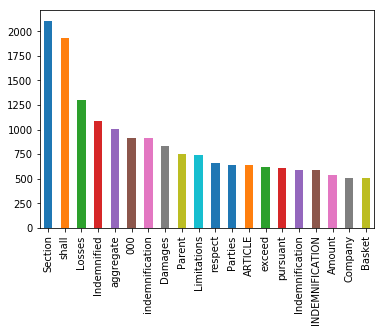

In [202]:
# Making bar graphs of the 20 most frequently appearing words for both basket and non-basket language

basket_words = pd.DataFrame(vect.transform(df['DocClause'].loc[df['IsBasket'] == 1].fillna(' ')).todense(),
                       columns=vect.get_feature_names())

word_counts1 = basket_words.sum(axis=0)
print(word_counts1.sort_values(ascending = False).head(20))
print(word_counts1.sort_values(ascending = False).head(20).plot.bar())

shall              847
Section            834
Limitations        675
INDEMNIFICATION    593
ARTICLE            536
Agreement          506
Party              505
Indemnified        480
claim              432
indemnification    423
respect            422
Indemnification    401
Company            387
Parent             381
Closing            330
Time               304
10                 300
party              261
Claim              240
Article            238
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


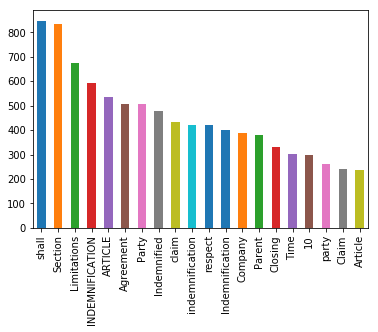

In [203]:
non_basket_words = pd.DataFrame(vect.transform(df['DocClause'].loc[df['IsBasket'] == 0].fillna(' ')).todense(),
                       columns=vect.get_feature_names())

word_counts2 = non_basket_words.sum(axis=0)
print(word_counts2.sort_values(ascending = False).head(20))
print(word_counts2.sort_values(ascending = False).head(20).plot.bar())

We can see already that the two sets have some different words. The most obvious is that basket_words contains the word 'basket', which is not present in the top 20 for non_basket. Also, basket_words contains more instances of '000', which may indicate there are more dollar amounts in basket language.

## 3a. Predictive Model

In [204]:
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred = nb.predict(X_test_dtm)

# Calculate accuracy.
metrics.accuracy_score(y_test, y_pred)

0.9404761904761905

In [205]:
# the model significantly outperforms the dummy.

from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(X_train_dtm, y_train).score(X_test_dtm, y_test)

0.4880952380952381

Text(0.5,15,'Predicted label')

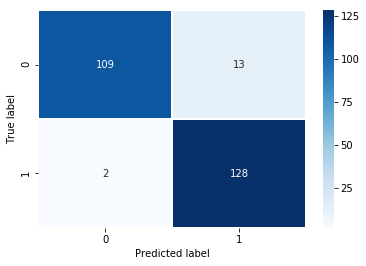

In [206]:
# We do seem to predict a few false positives

import seaborn as sns
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap="Blues")

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [207]:
# Let's try again with 1 & 2 ngrams (unique). The result further improves
vect = CountVectorizer(ngram_range=(1,2), min_df = 2, stop_words = 'english', lowercase=False)

X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred = nb.predict(X_test_dtm)

metrics.accuracy_score(y_test, y_pred)

0.9523809523809523

In [208]:
# It appears a logistic regression gives a better result still.
# Note that the result is not actually 100%, but slightly lower due to rounding

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_dtm, y_train)
lr.score(X_test_dtm, y_test)

0.9761904761904762

Text(0.5,15,'Predicted label')

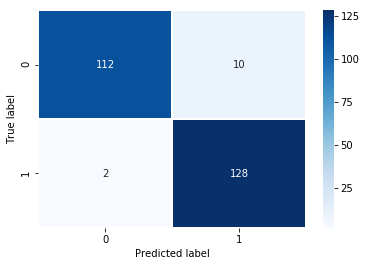

In [209]:
cm = metrics.confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap="Blues")

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [210]:
# Let's try lemmatizing the results to see if we get any improvement

clause = df['DocClause'].iloc[0]
print(clause)

ARTICLE 10 INDEMNIFICATION AND OTHER REMEDIES. ➤ 10.10 Further Limitations
10.10 Further Limitations . Notwithstanding anything to the contrary contained herein, no Indemnifying Party shall be liable to or otherwise responsible hereunder to any Indemnified Party for (i) incidental, consequential, special or indirect Losses, business interruption loss, loss of future revenue, diminution in value, lost profits or income, or loss of business reputation or opportunity or damages based on a multiplier of earnings or other financial measure that arise out of or related to this Agreement (other than any such Losses actually paid to a third party or in the case of Fraud), or...



In [211]:
import nltk
from nltk.tokenize import word_tokenize
word_tokenize(clause)

['ARTICLE',
 '10',
 'INDEMNIFICATION',
 'AND',
 'OTHER',
 'REMEDIES',
 '.',
 '➤',
 '10.10',
 'Further',
 'Limitations',
 '10.10',
 'Further',
 'Limitations',
 '.',
 'Notwithstanding',
 'anything',
 'to',
 'the',
 'contrary',
 'contained',
 'herein',
 ',',
 'no',
 'Indemnifying',
 'Party',
 'shall',
 'be',
 'liable',
 'to',
 'or',
 'otherwise',
 'responsible',
 'hereunder',
 'to',
 'any',
 'Indemnified',
 'Party',
 'for',
 '(',
 'i',
 ')',
 'incidental',
 ',',
 'consequential',
 ',',
 'special',
 'or',
 'indirect',
 'Losses',
 ',',
 'business',
 'interruption',
 'loss',
 ',',
 'loss',
 'of',
 'future',
 'revenue',
 ',',
 'diminution',
 'in',
 'value',
 ',',
 'lost',
 'profits',
 'or',
 'income',
 ',',
 'or',
 'loss',
 'of',
 'business',
 'reputation',
 'or',
 'opportunity',
 'or',
 'damages',
 'based',
 'on',
 'a',
 'multiplier',
 'of',
 'earnings',
 'or',
 'other',
 'financial',
 'measure',
 'that',
 'arise',
 'out',
 'of',
 'or',
 'related',
 'to',
 'this',
 'Agreement',
 '(',
 'other

In [212]:
import re
words = re.compile('\w+').findall(clause)

In [213]:
lemmatizer = WordNetLemmatizer()
[lemmatizer.lemmatize(word, 'v') for word in words]

['ARTICLE',
 '10',
 'INDEMNIFICATION',
 'AND',
 'OTHER',
 'REMEDIES',
 '10',
 '10',
 'Further',
 'Limitations',
 '10',
 '10',
 'Further',
 'Limitations',
 'Notwithstanding',
 'anything',
 'to',
 'the',
 'contrary',
 'contain',
 'herein',
 'no',
 'Indemnifying',
 'Party',
 'shall',
 'be',
 'liable',
 'to',
 'or',
 'otherwise',
 'responsible',
 'hereunder',
 'to',
 'any',
 'Indemnified',
 'Party',
 'for',
 'i',
 'incidental',
 'consequential',
 'special',
 'or',
 'indirect',
 'Losses',
 'business',
 'interruption',
 'loss',
 'loss',
 'of',
 'future',
 'revenue',
 'diminution',
 'in',
 'value',
 'lose',
 'profit',
 'or',
 'income',
 'or',
 'loss',
 'of',
 'business',
 'reputation',
 'or',
 'opportunity',
 'or',
 'damage',
 'base',
 'on',
 'a',
 'multiplier',
 'of',
 'earn',
 'or',
 'other',
 'financial',
 'measure',
 'that',
 'arise',
 'out',
 'of',
 'or',
 'relate',
 'to',
 'this',
 'Agreement',
 'other',
 'than',
 'any',
 'such',
 'Losses',
 'actually',
 'pay',
 'to',
 'a',
 'third',
 '

In [214]:
# Use default options for CountVectorizer.
vect = CountVectorizer(ngram_range=(1,2), min_df=2, stop_words = 'english', lowercase=False)

# Create document-term matrices.
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred = nb.predict(X_test_dtm)

# Calculate accuracy.
metrics.accuracy_score(y_test, y_pred)

0.9523809523809523

In [215]:
vect = CountVectorizer(ngram_range=(1, 2), min_df=2, stop_words='english')

X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

X_train_dtm.shape

(753, 8080)

In [216]:
vect.get_feature_names()[-20:]

['xii survival',
 'xii unless',
 'xiii',
 'xiii section',
 'xv',
 'xv indemnification',
 'yea',
 'year',
 'year anniversary',
 'year includible',
 'year indemnification',
 'year loss',
 'years',
 'years closing',
 'years following',
 'years notwithstanding',
 'years period',
 'york',
 'york ny',
 'zero']

In [217]:
nb.fit(X_train_dtm, y_train)
y_pred = nb.predict(X_test_dtm)

metrics.accuracy_score(y_test, y_pred)

0.9642857142857143

Text(0.5,15,'Predicted label')

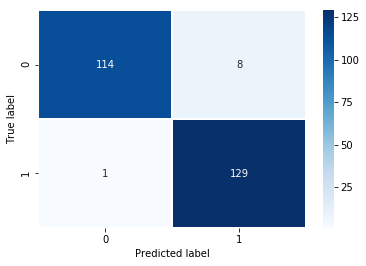

In [218]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap="Blues")

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [219]:
import re

def split_into_lemmas(text):
    
    # split text into individual words in a list
    words = re.compile('\w+').findall(text)
    
    # lemmatize
    return [lemmatizer.lemmatize(word, 'v') for word in words]

In [220]:
def tokenize_test(vect):
    
    X_train_dtm = vect.fit_transform(X_train)
    
    print('Features: ', X_train_dtm.shape[1])
    
    X_test_dtm = vect.transform(X_test)
    
    nb = MultinomialNB()
    
    nb.fit(X_train_dtm, y_train)
    
    y_pred = nb.predict(X_test_dtm)
    
    print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))

In [221]:
# a sampling of words

vect.get_feature_names()[1000:1200]

['arise breach',
 'arise dollar',
 'arise fr',
 'arise material',
 'arise result',
 'arise thereunder',
 'arises',
 'arises connection',
 'arising',
 'arising actual',
 'arising agreement',
 'arising article',
 'arising attributable',
 'arising based',
 'arising breach',
 'arising breaches',
 'arising claim',
 'arising claims',
 'arising connection',
 'arising directly',
 'arising facts',
 'arising following',
 'arising fraud',
 'arising inaccuracies',
 'arising inaccuracy',
 'arising incurrence',
 'arising indemnifiable',
 'arising indemnification',
 'arising intentional',
 'arising matters',
 'arising party',
 'arising pursuant',
 'arising qualifying',
 'arising related',
 'arising relating',
 'arising respect',
 'arising resulting',
 'arising section',
 'arising set',
 'arising similar',
 'arising substantially',
 'arising way',
 'arose',
 'arose reason',
 'arrangements',
 'arrangements indemnification',
 'arrangements limitations',
 'article',
 'article 10',
 'article 11',
 'articl

In [222]:
# Using lemmas appears to get our highest accuracy

vect = CountVectorizer(analyzer=split_into_lemmas, ngram_range=(3), stop_words = 'english')

tokenize_test(vect)

Features:  3069
Accuracy:  0.9563492063492064


## 3a. Predictive Model Using Clause Length Also

In [223]:
df.describe()

,Length,IsBasket
count,1005.000000,1005.000000
mean,1086.093532,0.496517
std,495.642102,0.500237
min,75.000000,0.000000
25%,667.000000,0.000000
50%,1093.000000,0.000000
75%,1480.000000,1.000000
max,2094.000000,1.000000


In [147]:
vect = CountVectorizer(stop_words = 'english', lowercase=False)

vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [224]:
X_train.drop(columns='DocClause').shape

(753,)

In [226]:
# Let's try looking at the new data we added to see if there are any trends

cols = df.columns.drop('DocClause')

X_scaled = preprocessing.MinMaxScaler().fit_transform(df[cols]) 

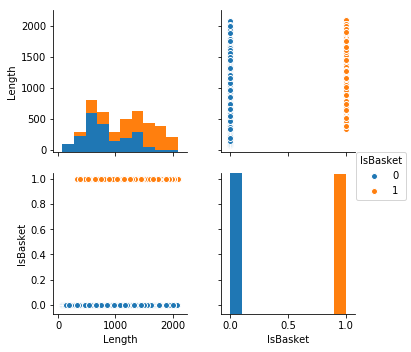

In [228]:
# if we look at Location relative to IsBasket, '1's are evenly distributed, making it hard to trend
# it does appear that shorter clauses tend to be '0', but it did not seem to affect accuracy much

sns.pairplot(df[cols], x_vars=cols, y_vars=cols, hue='IsBasket')

In [229]:
df['DocClause'] = df['DocClause'].fillna(' ')

In [231]:
feature_cols = ['DocClause', 'Length']
X = df[feature_cols]
y = df['IsBasket']

# Split the new DataFrame into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [232]:
X_train_dtm = vect.fit_transform(X_train['DocClause'])
X_test_dtm = vect.transform(X_test['DocClause'])
print((X_train_dtm.shape))
print((X_test_dtm.shape))

(753, 3069)
(252, 3069)


In [233]:
# attempting a logistic regression with multiple variables

extra = sp.sparse.csr_matrix(X_train.drop(columns='DocClause').astype(float))
extra.shape

(753, 1)

In [234]:
X_train_dtm_extra = sp.sparse.hstack((X_train_dtm, extra))
X_train_dtm_extra.shape

(753, 3070)

In [235]:
extra = sp.sparse.csr_matrix(X_test.drop(columns='DocClause').astype(float))
X_test_dtm_extra = sp.sparse.hstack((X_test_dtm, extra))
X_test_dtm_extra.shape

(252, 3070)

In [236]:
logreg = LogisticRegression(C=1e9)

logreg.fit(X_train_dtm, y_train)

y_pred = logreg.predict(X_test_dtm)

metrics.accuracy_score(y_test, y_pred)

0.9801587301587301

In [237]:
logreg = LogisticRegression(C=1e9)

logreg.fit(X_train_dtm_extra, y_train)

y_pred = logreg.predict(X_test_dtm_extra)

metrics.accuracy_score(y_test, y_pred)

0.9722222222222222

## 4. Just for fun

In [238]:
# Let's look at what are the most imporatant words found in random clause snippets

dtm = vect.fit_transform(df['DocClause'].fillna(' '))
features = vect.get_feature_names()

In [239]:
def summarize():
    
    # Choose a random review that is at least 300 characters.
    review_length = 0
    while review_length < 300:
        review_id = np.random.randint(0, len(df))
        review_text = df['DocClause'][review_id]
        review_length = len(review_text)
    
    # Create a dictionary of words and their TF–IDF scores.
    word_scores = {}
    for word in re.compile('\w+').findall(review_text):
        word = word.lower()
        if word in features:
            word_scores[word] = dtm[review_id, features.index(word)]
    
    # Print words with the top five TF–IDF scores.
    print('TOP SCORING WORDS:')
    top_scores = sorted(list(word_scores.items()), key=lambda x: x[1], reverse=True)[:5]
    for word, score in top_scores:
        print(word)
    
    # Print five random words.
    print(('\n' + 'RANDOM WORDS:'))
    random_words = np.random.choice(list(word_scores.keys()), size=5, replace=False)
    for word in random_words:
        print(word)
    
    # Print the review.
    print(('\n' + review_text))

In [240]:
summarize()

TOP SCORING WORDS:
the
to
and
5
in

RANDOM WORDS:
5
nothing
seek
as
6

ARTICLE 5 INDEMNIFICATION; REMEDIES ➤ 5.8. Exclusive Remedy; Further Limitations
5.8. Exclusive Remedy; Further Limitations . Except with respect to fraud, the right to seek specific performance or injunctive relief to enforce a party's covenants and obligations in any Transaction Agreement or as provided in Section 4.13(c) and Section 6.2 , the indemnification provisions set forth in this Article 5 shall be the sole and exclusive remedy of the parties hereto with respect to any and all claims from and after the Closing Date arising out of the subject matter of this Agreement. For the avoidance of doubt, nothing contained in this Agreement shall be construed to limit the P...

